In [1]:
import h2o
import operator
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
from matplotlib import pyplot as plt
import warnings
import sys
sys.path.append('../plot/')
from ice import ice, ice_plot
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGradientBoostingEstimator
warnings.filterwarnings("ignore")
from h2o.estimators.random_forest import H2ORandomForestEstimator
from IPython.display import Image, display
from h2o.backend import H2OLocalServer
import subprocess
import shutil
%matplotlib inline

# Abstract 
## Prototype Testing

Based on the prototype we generate from **Amazon Reviews** dataset, now we fit a new dataset named **Yelp Reviews** into the prototype to validate how well does our prototype fit. 

# 1 Data Preparation

## 1.1 H2O Initialization

In [2]:
pct_memory=4
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

27


In [3]:
h2o.init(strict_version_check=False,max_mem_size=min_mem_size)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 day 3 hours 51 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,10 days
H2O cluster name:,H2O_from_python_mandy_jpex0n
H2O cluster total nodes:,1
H2O cluster free memory:,24.57 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


## 1.2 Data Import & Parse

In [4]:
data_path = "../data/yelp.csv"

# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
reviews.shape

(10086, 10)

In [6]:
reviews.head(3)

business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,"My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better. Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I've ever had. I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing. While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best ""toast"" I've ever had. Anyway, I can't wait to go back!",review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
ZRJwVLyzEJq1VAihDhYiow,2011-07-27 00:00:00,IjZ33sJrzXqU-0X6U8NwyA,5,"I have no idea why some people give bad reviews about this place. It goes to show you, you can please everyone. They are probably griping about something that their own fault...there are many people like that. In any case, my friend and I arrived at about 5:50 PM this past Sunday. It was pretty crowded, more than I thought for a Sunday evening and thought we would have to wait forever to get a seat but they said we'll be seated when the girl comes back from seating someone else. We were seated at 5:52 and the waiter came and got our drink orders. Everyone was very pleasant from the host that seated us to the waiter to the server. The prices were very good as well. We placed our orders once we decided what we wanted at 6:02. We shared the baked spaghetti calzone and the small ""Here's The Beef"" pizza so we can both try them. The calzone was huge and we got the smallest one (personal) and got the small 11"" pizza. Both were awesome! My friend liked the pizza better and I liked the calzone better. The calzone does have a sweetish sauce but that's how I like my sauce! We had to box part of the pizza to take it home and we were out the door by 6:42. So, everything was great and not like these bad reviewers. That goes to show you that you have to try these things yourself because all these bad reviewers have some serious issues.",review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
6oRAC4uyJCsJl1X0WZpVSA,2012-06-14 00:00:00,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I also dig their candy selection :),review,0hT2KtfLiobPvh6cDC8JQg,0,1,0


In [7]:
reviews['PositiveReview']=(reviews['stars']>=reviews['stars'].mean()[0]).ifelse('1','0')

In [8]:
reviews['PositiveReview'].table()

PositiveReview,Count
0,3222
1,6864


In [9]:
cols_df = h2o.H2OFrame.from_python(np.transpose(list(range(1, 10087))), column_names=list(['Id']))
cols_df.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(10086, 1)

In [10]:
reviews = cols_df.cbind(reviews)
reviews.head(3)

Id,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,PositiveReview
1,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,"My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better. Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I've ever had. I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing. While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best ""toast"" I've ever had. Anyway, I can't wait to go back!",review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,1
2,ZRJwVLyzEJq1VAihDhYiow,2011-07-27 00:00:00,IjZ33sJrzXqU-0X6U8NwyA,5,"I have no idea why some people give bad reviews about this place. It goes to show you, you can please everyone. They are probably griping about something that their own fault...there are many people like that. In any case, my friend and I arrived at about 5:50 PM this past Sunday. It was pretty crowded, more than I thought for a Sunday evening and thought we would have to wait forever to get a seat but they said we'll be seated when the girl comes back from seating someone else. We were seated at 5:52 and the waiter came and got our drink orders. Everyone was very pleasant from the host that seated us to the waiter to the server. The prices were very good as well. We placed our orders once we decided what we wanted at 6:02. We shared the baked spaghetti calzone and the small ""Here's The Beef"" pizza so we can both try them. The calzone was huge and we got the smallest one (personal) and got the small 11"" pizza. Both were awesome! My friend liked the pizza better and I liked the calzone better. The calzone does have a sweetish sauce but that's how I like my sauce! We had to box part of the pizza to take it home and we were out the door by 6:42. So, everything was great and not like these bad reviewers. That goes to show you that you have to try these things yourself because all these bad reviewers have some serious issues.",review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1
3,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14 00:00:00,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I also dig their candy selection :),review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,1


In [11]:
split = reviews["Id"].quantile(prob = [0.8])[1]
reviews["Train"] = (reviews["Id"] < split).ifelse("Yes", "No")

In [12]:
reviews['Train'].table()

Train,Count
No,2018
Yes,8068


In [13]:
train = reviews[reviews["Train"] == "Yes"]
test = reviews[reviews["Train"] == "No"]

In [14]:
train.head()

Id,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,PositiveReview,Train
1,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,"My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better. Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I've ever had. I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing. While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best ""toast"" I've ever had. Anyway, I can't wait to go back!",review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,1,Yes
2,ZRJwVLyzEJq1VAihDhYiow,2011-07-27 00:00:00,IjZ33sJrzXqU-0X6U8NwyA,5,"I have no idea why some people give bad reviews about this place. It goes to show you, you can please everyone. They are probably griping about something that their own fault...there are many people like that. In any case, my friend and I arrived at about 5:50 PM this past Sunday. It was pretty crowded, more than I thought for a Sunday evening and thought we would have to wait forever to get a seat but they said we'll be seated when the girl comes back from seating someone else. We were seated at 5:52 and the waiter came and got our drink orders. Everyone was very pleasant from the host that seated us to the waiter to the server. The prices were very good as well. We placed our orders once we decided what we wanted at 6:02. We shared the baked spaghetti calzone and the small ""Here's The Beef"" pizza so we can both try them. The calzone was huge and we got the smallest one (personal) and got the small 11"" pizza. Both were awesome! My friend liked the pizza better and I liked the calzone better. The calzone does have a sweetish sauce but that's how I like my sauce! We had to box part of the pizza to take it home and we were out the door by 6:42. So, everything was great and not like these bad reviewers. That goes to show you that you have to try these things yourself because all these bad reviewers have some serious issues.",review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1,Yes
3,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14 00:00:00,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I also dig their candy selection :),review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,1,Yes
4,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27 00:00:00,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!! It's very convenient and surrounded by a lot of paths, a desert xeriscape, baseball fields, ballparks, and a lake with ducks. The Scottsdale Park and Rec Dept. does a wonderful job of keeping the park clean and shaded. You can find trash cans and poopy-pick up mitts located all over the park and paths. The fenced in area is huge to let the dogs run, play, and sniff!",review,uZetl9T0NcROGOyFfughhg,1,2,0,1,Yes
5,6ozycU1RpktNG2-1BroVtw,2012-01-05 00:00:00,1uJFq2r5QfJG_6ExMRCaGw,5,"General Manager Scott Petello is a good egg!!! Not to go into detail, but let me assure you if you have any issues (albeit rare) speak with Scott and treat the guy with some respect as you state your case and I'd be surprised if you don't walk out totally satisfied as I just did. Like I always say..... ""Mistakes are inevitable, it's how we recover from them that is important""!!! Thanks to Scott and his awesome staff. You've got a customer for life!! .......... :^)",review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,1,Yes
6,-yxfBYGB6SEqszmxJxd97A,2007-12-13 00:00:00,m2CKSsepBCoRYWxiRUsxAg,4,"Quiessence is, simply put, beautiful. Full windows and earthy wooden walls g

## 1.3 Tokenize Words in Review

In [15]:
data_path = "../data/stopwords.csv"
STOP_WORDS = pd.read_csv(data_path, header=0)

In [16]:
STOP_WORDS.head()

,STOP_WORD
0,all
1,just
2,being
3,over
4,both


In [17]:
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [18]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [19]:
# Break reviews into sequence of words
words = tokenize(reviews["text"])

In [20]:
words.head()

C1
wife
took
birthday
breakfast
excellent
weather
perfect
made
sitting
outside


## 1.4 Word2Vec Model

In [21]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator

w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v_yelp.hex")
w2v_model.train(training_frame=words)

models_path='../data'
h2o.save_model(w2v_model, path = models_path, force = True)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


'/Users/mandy/Desktop/AI-Addin/data/w2v_yelp.hex'

In [22]:
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("awesome", count = 5)

OrderedDict([('great', 0.696063756942749),
             ('amazing', 0.6426021456718445),
             ('terrific', 0.595786452293396),
             ('fantastic', 0.5885162949562073),
             ('good', 0.5785609483718872)])

In [23]:
# Sanity check - find synonyms for the word 'stale'
w2v_model.find_synonyms("boring", count = 5)

OrderedDict([('strangely', 0.6305074095726013),
             ('rotting', 0.5694159269332886),
             ('overkill', 0.5645906925201416),
             ('panera', 0.556342363357544),
             ('sorta', 0.5528005957603455)])

In [24]:
# Calculate a vector for each review
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.0343281,0.0051937,-0.0245672,-0.106463,-0.054045,0.0180256,0.0224414,0.0438261,0.117291,0.0816551,-0.0917997,0.110579,0.044647,0.113278,-0.0150673,-0.0518388,0.0646034,0.13636,-0.00916306,-0.132055,0.13719,0.149723,-0.00878397,0.0589136,-0.139307,-0.0913946,0.0224817,-0.149464,0.0452012,0.0881054,0.0435377,-0.0912452,-0.0891477,0.0759915,-0.0374916,-0.0330145,0.00811467,0.119047,0.071931,0.125339,-0.0840357,-0.00757008,0.165492,-0.197233,-0.0141336,-0.0172586,-0.0137922,0.0123828,-0.113145,-0.156697,0.0265886,0.0374107,0.0235846,0.0464472,0.033401,0.0682564,-0.134042,-0.0745239,0.0323346,-0.027096,0.0481875,0.0129453,-0.0400582,-0.0946364,-0.303968,0.00707451,-0.0893795,-0.0855134,0.054413,0.0330866,-0.0205429,-0.129844,0.0847582,-0.0727914,-0.0408743,0.0329011,0.0735403,0.0473638,-0.0459,0.105538,-0.09764,-0.0161386,-0.123831,-0.0304546,0.112998,0.0121958,-0.0713902,-0.0197902,-0.0483563,-0.128037,-0.0403236,-0.0465174,0.0251486,-0.0279464,0.139331,-0.0724418,-0.0504423,-0.0277931,0.116634,-0.0308462
-0.00841888,-0.0367978,-0.047984,-0.107606,-0.0219806,-0.027872,0.000653989,0.0453759,0.0130019,0.040644,-0.0764674,0.13355,-0.030872,0.0219543,0.0237537,-0.0328355,-0.0933646,0.161624,0.000346165,-0.113175,0.136126,0.089586,-0.0885865,0.0329941,-0.140539,-0.0914314,0.00623669,-0.0849305,0.159952,0.114218,0.107808,-0.157676,-0.119522,0.0166978,-0.0957968,-0.0479572,-0.0283279,0.0559837,0.122109,0.0446514,-0.0468297,-0.0272921,0.124865,-0.175801,-0.0413519,0.0834426,0.0497006,0.0192517,-0.0865838,-0.144666,-0.00802182,-0.00175738,-0.0219449,-0.00183098,0.0348845,0.0845883,-0.0425108,0.00238536,0.00870894,-0.00285003,0.0297898,-0.00476341,-0.0781029,-0.0278536,-0.253907,0.0158777,-0.117294,-0.100079,-0.0178486,-0.0160428,-0.0477334,-0.089798,0.100978,-0.0791975,-0.114953,-0.016178,0.113239,-0.0297244,-0.0507682,0.0992245,-0.15554,0.00504671,-0.150387,0.0190772,0.1118,-0.00459585,-0.0623446,-0.0738057,-0.0834849,-0.113327,-0.0350367,-0.0121368,-0.0029645,-0.0370992,0.126308,-0.0599892,0.018899,0.0128863,0.153313,0.0307532
0.106812,-0.0531791,-0.248746,-0.0964067,0.00543761,-0.118796,-0.0136284,0.0783703,0.196345,0.0693098,0.107166,0.153927,0.119485,0.0463026,0.0512368,-0.0345272,0.122907,0.111512,0.0664691,-0.0824142,0.121341,0.0338146,-0.115247,0.151593,-0.169323,-0.137561,-0.0309921,-0.0602049,0.185922,0.120305,-0.0204564,-0.118511,-0.00391995,-0.179139,0.00421855,-0.0543187,0.120564,0.129863,0.108769,-0.0332906,0.0283462,-0.102291,0.098346,-0.292718,0.0941237,-0.0555223,-0.0988362,0.08682,-0.109796,-0.139637,0.0492426,-0.104476,0.0496559,0.0206377,0.158935,0.0126514,-0.229335,0.0183904,-0.0979047,0.00211685,0.0829323,0.03935,-0.0895552,-0.104161,-0.240879,-0.00877929,0.013402,-0.133122,0.138624,0.0694711,-0.136077,-0.162259,-0.0742026,-0.103819,0.0148084,0.0417735,0.148551,-0.0128271,-0.0116661,0.137422,0.0475243,-0.120598,-0.0184198,0.0515959,0.127608,0.0308245,-0.224001,-0.0549651,0.00999353,-0.242361,-0.0594783,-0.0533221,0.0297955,-0.125598,0.00814142,-0.0036272,-0.0210787,-0.0652238,0.163264,0.0766767
0.149575,0.00877935,-0.0305424,-0.0615285,-0.171822,-0.0289194,0.00763918,0.104275,0.0483289,0.000883941,-0.131904,0.0131315,-0.0888993,0.0365797,-0.0843292,0.0383369,-0.0740799,-0.0140469,-0.0253985,-0.0903809,0.0322422,-0.0560512,-0.021445,-0.0450116,-0.215233,-0.0876513,-0.0608783,0.00691818,0.126002,0.16024,-0.0152789,-0.197581,0.068207,0.138345,0.0679399,0.0707045,0.0374281,0.172593,0.00786486,-0.0443255,-0.283468,-0.000710523,0.111304,-0.0187323,0.0664693,-0.0907029,0.0227588,-0.0103433,0.00361265,-0.110028,-0.0609965,0.0197214,-0.0569

In [25]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)

In [26]:
ext_reviews = ext_reviews.drop([1, 5])

In [27]:
ext_reviews.head(3)

Id,date,review_id,stars,type,user_id,cool,useful,funny,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
1,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,1,Yes,0.0343281,0.0051937,-0.0245672,-0.106463,-0.054045,0.0180256,0.0224414,0.0438261,0.117291,0.0816551,-0.0917997,0.110579,0.044647,0.113278,-0.0150673,-0.0518388,0.0646034,0.13636,-0.00916306,-0.132055,0.13719,0.149723,-0.00878397,0.0589136,-0.139307,-0.0913946,0.0224817,-0.149464,0.0452012,0.0881054,0.0435377,-0.0912452,-0.0891477,0.0759915,-0.0374916,-0.0330145,0.00811467,0.119047,0.071931,0.125339,-0.0840357,-0.00757008,0.165492,-0.197233,-0.0141336,-0.0172586,-0.0137922,0.0123828,-0.113145,-0.156697,0.0265886,0.0374107,0.0235846,0.0464472,0.033401,0.0682564,-0.134042,-0.0745239,0.0323346,-0.027096,0.0481875,0.0129453,-0.0400582,-0.0946364,-0.303968,0.00707451,-0.0893795,-0.0855134,0.054413,0.0330866,-0.0205429,-0.129844,0.0847582,-0.0727914,-0.0408743,0.0329011,0.0735403,0.0473638,-0.0459,0.105538,-0.09764,-0.0161386,-0.123831,-0.0304546,0.112998,0.0121958,-0.0713902,-0.0197902,-0.0483563,-0.128037,-0.0403236,-0.0465174,0.0251486,-0.0279464,0.139331,-0.0724418,-0.0504423,-0.0277931,0.116634,-0.0308462
2,2011-07-27 00:00:00,IjZ33sJrzXqU-0X6U8NwyA,5,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1,Yes,-0.00841888,-0.0367978,-0.047984,-0.107606,-0.0219806,-0.027872,0.000653989,0.0453759,0.0130019,0.040644,-0.0764674,0.13355,-0.030872,0.0219543,0.0237537,-0.0328355,-0.0933646,0.161624,0.000346165,-0.113175,0.136126,0.089586,-0.0885865,0.0329941,-0.140539,-0.0914314,0.00623669,-0.0849305,0.159952,0.114218,0.107808,-0.157676,-0.119522,0.0166978,-0.0957968,-0.0479572,-0.0283279,0.0559837,0.122109,0.0446514,-0.0468297,-0.0272921,0.124865,-0.175801,-0.0413519,0.0834426,0.0497006,0.0192517,-0.0865838,-0.144666,-0.00802182,-0.00175738,-0.0219449,-0.00183098,0.0348845,0.0845883,-0.0425108,0.00238536,0.00870894,-0.00285003,0.0297898,-0.00476341,-0.0781029,-0.0278536,-0.253907,0.0158777,-0.117294,-0.100079,-0.0178486,-0.0160428,-0.0477334,-0.089798,0.100978,-0.0791975,-0.114953,-0.016178,0.113239,-0.0297244,-0.0507682,0.0992245,-0.15554,0.00504671,-0.150387,0.0190772,0.1118,-0.00459585,-0.0623446,-0.0738057,-0.0834849,-0.113327,-0.0350367,-0.0121368,-0.0029645,-0.0370992,0.126308,-0.0599892,0.018899,0.0128863,0.153313,0.0307532
3,2012-06-14 00:00:00,IESLBzqUCLdSzSqm0eCSxQ,4,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,1,Yes,0.106812,-0.0531791,-0.248746,-0.0964067,0.00543761,-0.118796,-0.0136284,0.0783703,0.196345,0.0693098,0.107166,0.153927,0.119485,0.0463026,0.0512368,-0.0345272,0.122907,0.111512,0.0664691,-0.0824142,0.121341,0.0338146,-0.115247,0.151593,-0.169323,-0.137561,-0.0309921,-0.0602049,0.185922,0.120305,-0.0204564,-0.118511,-0.00391995,-0.179139,0.00421855,-0.0543187,0.120564,0.129863,0.108769,-0.0332906,0.0283462,-0.102291,0.098346,-0.292718,0.0941237,-0.0555223,-0.0988362,0.08682,-0.109796,-0.139637,0.0492426,-0.104476,0.0496559,0.0206377,0.158935,0.0126514,-0.229335,0.0183904,-0.0979047,0.00211685,0.0829323,0.03935,-0.0895552,-0.104161,-0.240879,-0.00877929,0.013402,-0.133122,0.138624,0.0694711,-0.136077,-0.162259,-0.0742026,-0.103819,0.0148084,0.0417735,0.148551,-0.0128271,-0.0116661,0.137422,0.0475243,-0.120598,-0.0184198,0.0515959,0.127608,0.0308245,-0.224001,-0.0549651,0.00999353,-0.242361,-0.0594783,-0.0533221,0.0297955,-0.125598,0.00814142,-0.0036272,-0.0210787,-0.0652238,0.163264,0.0766767


In [28]:
ext_train = ext_reviews[ext_reviews["Train"] == "Yes"]
ext_test = ext_reviews[ext_reviews["Train"] == "No"]

In [29]:
predictors = ['date','review_id','user_id','cool','useful','funny'] + review_vecs.names
response = 'PositiveReview'

## 1.5 Leaderboard

H2O’s AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit. With the help of Auto ML, we are able to find the “best” model from building large number of models without any prior knowledge.

In [90]:
aml = H2OAutoML()

In [92]:
aml.train(x=predictors,y=response,training_frame=ext_test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [93]:
print(aml.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190426_140523,0.846889,0.436274,0.275104,0.374472,0.140229
GLM_grid_1_AutoML_20190426_140523_model_1,0.84419,0.44428,0.271968,0.376596,0.141824
XGBoost_grid_1_AutoML_20190426_140523_model_8,0.843375,0.440441,0.260929,0.377569,0.142559
DeepLearning_grid_1_AutoML_20190426_140523_model_1,0.841085,0.466155,0.280023,0.382047,0.14596
XGBoost_2_AutoML_20190426_140523,0.840194,0.448026,0.32472,0.380326,0.144648
XGBoost_grid_1_AutoML_20190426_140523_model_10,0.839452,0.450697,0.317931,0.380994,0.145157
XGBoost_grid_1_AutoML_20190426_140523_model_3,0.83757,0.455414,0.298487,0.383773,0.147282
XGBoost_3_AutoML_20190426_140523,0.837124,0.45012,0.307592,0.381667,0.14567
GBM_5_AutoML_20190426_140523,0.836641,0.452982,0.327585,0.383299,0.146918
XGBoost_grid_1_AutoML_20190426_140523_model_2,0.836577,0.455647,0.303127,0.383852,0.147342


# 2 Training Models

On the aspect of training model, we take the advantage of H2O library and run the leaderboard of models which can fit the dataset best. Beside some advanced models such as GBM and XGBoost, we also train some basic models like Generalized Linear Model and Logistic Regression. These models may seem easy to train and use, but very useful and powerful regards fitting various types of datasets.

In order to compare our models in a same standard, we will use the score of AUC to do so. Since our target is binomial variable, ROC is one of the best matrixes to evaluate the accuracy. And the score of AUC would allow us to compare the models easily and accurately.

## 2.1 Generalized Linear Model

### 2.1.1 Train & Fit Model

In [30]:
# Initialize
local_glm_plus = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_surrogate', lambda_search=True)
# train
local_glm_plus.train(x=predictors, y=response, training_frame=ext_train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.1.2 Interpretability

#### Variable Importance

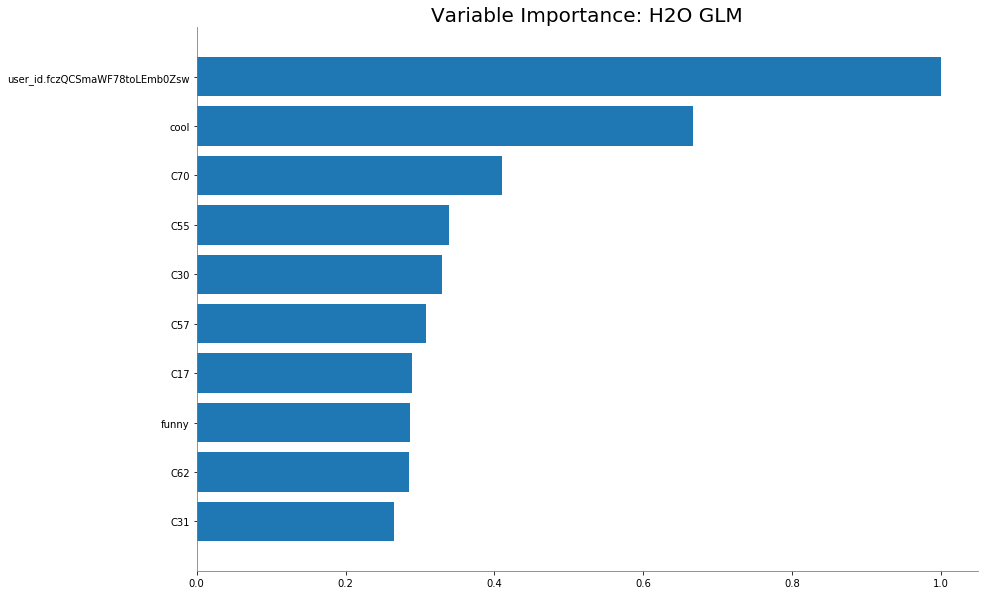

In [31]:
local_glm_plus.varimp_plot()

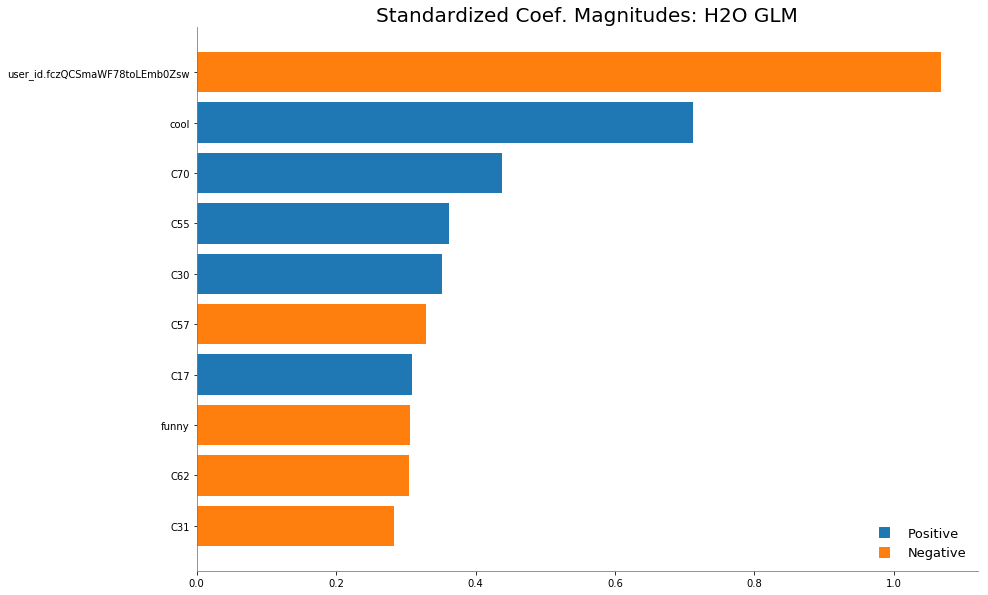

In [32]:
local_glm_plus.std_coef_plot(10)

We can get that the feature "user_id" is the most important.

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


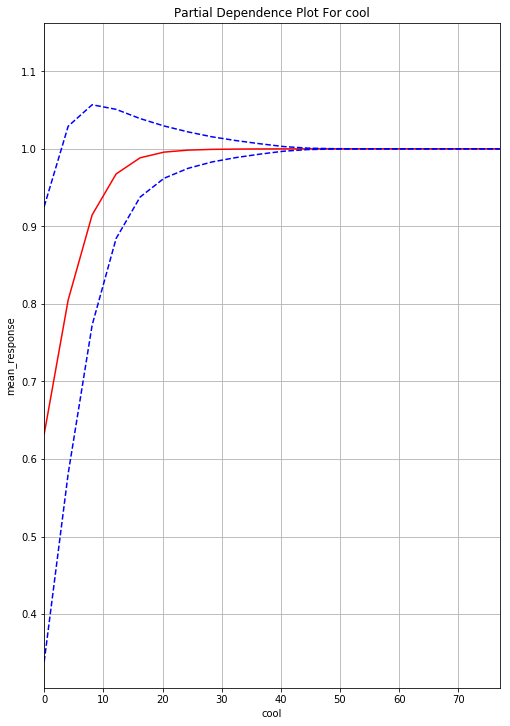

In [32]:
pdp_local_linear_plus = local_glm_plus.partial_plot(data = ext_train, cols = ["cool"])

PDP for the above model shows that the positive reviews always have a large "cool" score.

#### Individual Conditional Expectation (ICE)

In [33]:
cool_ice_df = ice(data=ext_test, column='cool', model=local_glm_plus)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


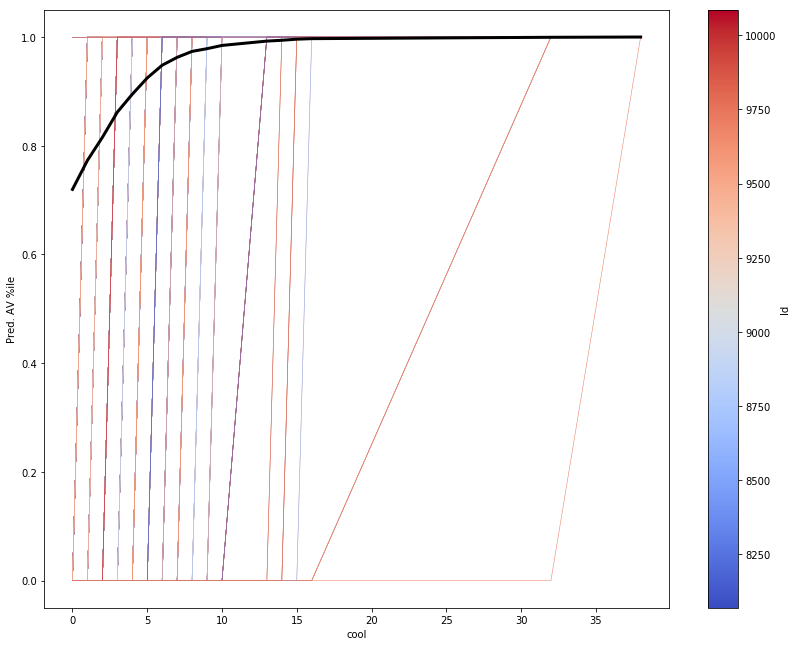

In [34]:
ice_plot(cool_ice_df, linewidth=0.5, color_by='Id', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = cool_ice_df.columns.get_level_values('Id').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Id')
plt.ylabel('Pred. AV %ile')
plt.xlabel('cool');

We can get the reviews always be positive review when it's "cool" is bigger than 15.

### 2.1.3 Matrix

In [35]:
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm_plus.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))


Local GLM Coefficients:
C57:                      -8.594726580121552
C39:                      -7.3208790035793125
C81:                      -5.870814738697572
C87:                      -4.763604749498106
C28:                      -4.28811762025089
C8:                       -3.846956499623903
C68:                      -3.554062859439307
C77:                      -2.974311610347793
C69:                      -2.9312228975349037
C60:                      -2.864639227654928
C3:                       -2.836899903041565
C66:                      -2.7235410870373533
C18:                      -2.6960967832141343
C5:                       -2.4170008998886012
C9:                       -2.291801234567416
C41:                      -2.0831181646950223
C45:                      -1.824384653754121
C73:                      -1.7007444592797198
C19:                      -1.679029815537069
C46:                      -1.6010295297841046
C32:                      -1.581128632929471
C1:                    

In [36]:
local_glm_plus.r2(train=True, valid=True)

{'train': 0.4050321890911117, 'valid': None}

In [37]:
local_glm_plus.auc()

0.8755778023183839

In [38]:
local_glm_plus.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44035705674440273: 


,0,1,Error,Rate
0,1447.0,1153.0,0.4435,(1153.0/2600.0)
1,374.0,5094.0,0.0684,(374.0/5468.0)
Total,1821.0,6247.0,0.1893,(1527.0/8068.0)


## 2.2 Logistic Regression

### 2.2.1 Train & Fit Model

In [39]:
glm_logistic_plus_summary = H2OGeneralizedLinearEstimator(family = "binomial")
glm_logistic_plus_summary.train(x=predictors, 
                               y= response, 
                               training_frame = ext_train, 
                               validation_frame = ext_test, 
                               model_id="glm_logistic")

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.2.2 Interpretability

#### Variable Importance

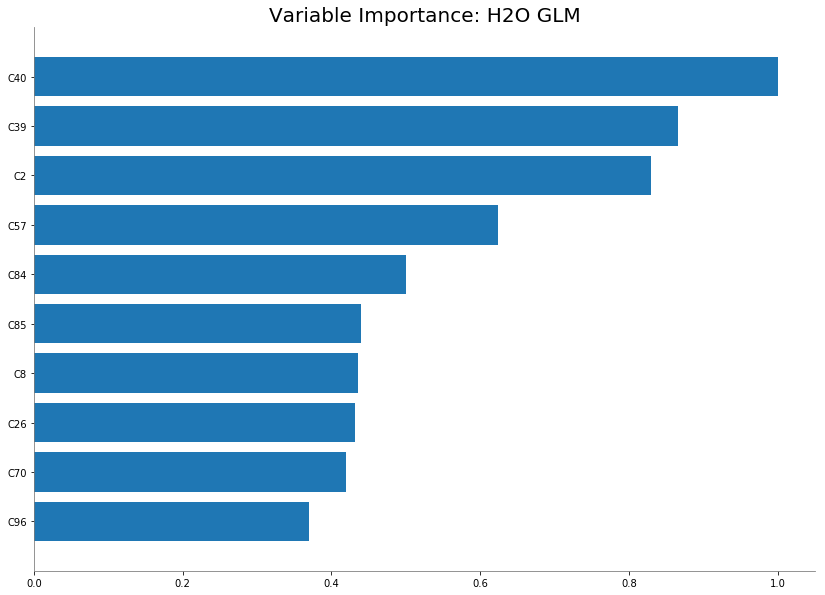

In [40]:
glm_logistic_plus_summary.varimp_plot()

We can get that the feature "C40" is the most important.

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


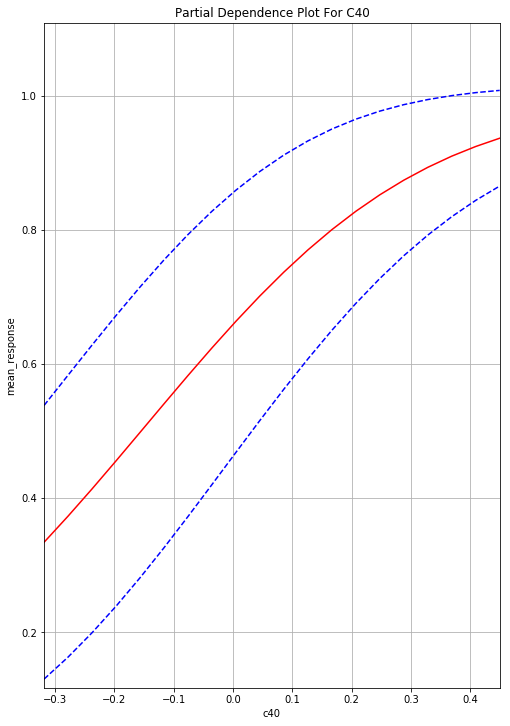

In [41]:
pdp_word_vecs = glm_logistic_plus_summary.partial_plot(data = ext_train, cols = ["C40"])

PDP for the above model shows that the positive reviews always have a large "C40" score.

#### Individual Conditional Expectation (ICE)

In [42]:
ext_train_lice = h2o.H2OFrame(ext_train.as_data_frame().iloc[::25])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [43]:
C40_ice_df = ice(data=ext_train_lice, column='C40', model=glm_logistic_plus_summary)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


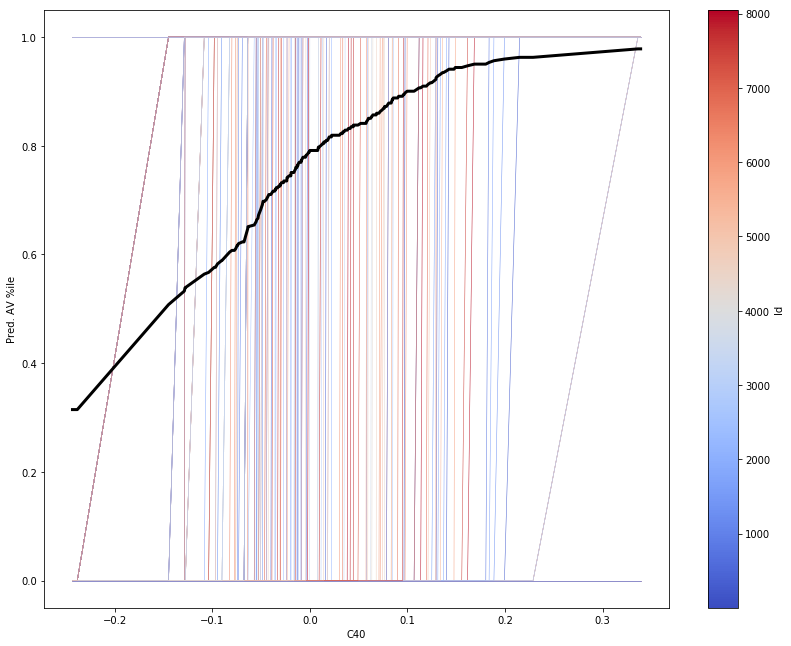

In [44]:
ice_plot(C40_ice_df, linewidth=0.5, color_by='Id', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C40_ice_df.columns.get_level_values('Id').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Id')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C40');

We can get the reviews always be positive review when it's "C40" is bigger than 0.3.

### 2.2.3 Matrix

In [45]:
print("With Summary and Review Embeddings AUC: " + str(round(glm_logistic_plus_summary.auc(valid = True), 3)))

With Summary and Review Embeddings AUC: 0.846


In [46]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5021211758121095: 


,0,1,Error,Rate
0,331.0,291.0,0.4678,(291.0/622.0)
1,114.0,1282.0,0.0817,(114.0/1396.0)
Total,445.0,1573.0,0.2007,(405.0/2018.0)


In [47]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5021211758121095: 


,0,1,Error,Rate
0,331.0,291.0,0.4678,(291.0/622.0)
1,114.0,1282.0,0.0817,(114.0/1396.0)
Total,445.0,1573.0,0.2007,(405.0/2018.0)


## 2.3 Gradient Boosting Model I

In [48]:
# define a function to remove all the intermediate file.
def cleanPath(projectName, model, zipFile):
    path = '../plot/decisionTree/' + projectName + '/' + model
    if not os.path.exists(path):
        os.makedirs(path)            
        print ("---  new folder...  ---")
        print (path)
        print ("-------   OK  ---------")
    else:
        print ("-------   OK  ---------")
    
    shutil.move('../data/'+zipFile, path + '/'+model+'_hex.zip')
    shutil.move('dt_surrogate_mojo.gv', path + '/dt_surrogate_mojo.gv')
    shutil.move('dt_surrogate_mojo.png', path + '/dt_surrogate_mojo.png')

### 2.3.1 Train & Fit Model

In [49]:
# initialize single tree surrogate model
model_id = 'dt_surrogate_mojo'

# train single tree surrogate model
surrogate = H2OGradientBoostingEstimator(ntrees=1,
                                         sample_rate=1,
                                         col_sample_rate=1,
                                         max_depth=3,
                                         seed=12345,
                                         model_id=model_id)

_ = surrogate.train(x=predictors, y=response, training_frame=ext_train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [50]:
# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='../data')

print(surrogate)
print('Generated MOJO path:\n', mojo_path)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.2108478881405354
RMSE: 0.4591817593726208
LogLoss: 0.6114939539864253
Mean Per-Class Error: 0.3104958921838952
AUC: 0.7409740940295988
pr_auc: 0.4355149927107001
Gini: 0.4819481880591976
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6586455151645662: 


,0,1,Error,Rate
0,631.0,1969.0,0.7573,(1969.0/2600.0)
1,214.0,5254.0,0.0391,(214.0/5468.0)
Total,845.0,7223.0,0.2706,(2183.0/8068.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6586455,0.8279883,5.0
max f2,0.6277768,0.9131597,7.0
max f0point5,0.6751072,0.7972470,3.0
max accuracy,0.6623917,0.7305404,4.0
max precision,0.6959134,0.8623188,0.0
max recall,0.6277768,1.0,7.0
max specificity,0.6959134,0.8465385,0.0
max absolute_mcc,0.6751072,0.3693586,3.0
max min_per_class_accuracy,0.6828087,0.6396154,2.0
max mean_per_class_accuracy,0.6828087,0.6895041,2.0


Gains/Lift Table: Avg response rate: 67.77 %, avg score: 67.74 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.3591968,0.6959134,1.2723461,1.2723461,0.8623188,0.6959134,0.8623188,0.6959134,0.4570227,0.4570227,27.2346087,27.2346087
,2,0.4039415,0.6901673,1.1852997,1.2627039,0.8033241,0.6901673,0.8557840,0.6952769,0.0530358,0.5100585,18.5299714,26.2703945
,3,0.6172533,0.6828087,1.0751128,1.1978758,0.7286461,0.6828087,0.8118474,0.6909681,0.2293343,0.7393928,7.5112843,19.7875775
,4,0.8415964,0.6623917,0.8143747,1.0956465,0.5519337,0.6650120,0.7425626,0.6840490,0.1826993,0.9220922,-18.5625255,9.5646487
,5,0.9252603,0.6490174,0.6732623,1.0574537,0.4562963,0.6551937,0.7166778,0.6814399,0.0563277,0.9784199,-32.6737652,5.7453682
,6,1.0,0.6277768,0.2887368,1.0,0.1956882,0.6277768,0.6777392,0.6774291,0.0215801,1.0,-71.1263240,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-26 20:46:40,0.062 sec,0.0,0.4673422,0.6285618,0.5,0.0,1.0,0.3222608
,2019-04-26 20:46:40,0.110 sec,1.0,0.4591818,0.6114940,0.7409741,0.4355150,1.2723461,0.2705751


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
C2,161.3866882,1.0,0.5095072
C40,45.5410309,0.2821858,0.1437757
C70,37.0551262,0.2296046,0.1169852
C39,31.7017784,0.1964337,0.1000844
C96,21.7721481,0.1349067,0.0687359
---,---,---,---
C95,0.0,0.0,0.0
C97,0.0,0.0,0.0
C98,0.0,0.0,0.0
C99,0.0,0.0,0.0



See the whole table with table.as_data_frame()

Generated MOJO path:
 /Users/mandy/Desktop/AI-Addin/data/dt_surrogate_mojo.zip


In [51]:
details = False # print more info on tree, details = True
title = 'Yelp Reviews Decision Tree Surrogate'

hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o ').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)

if details:
    gv_args.append('--detail')

if title is not None:
    gv_args = gv_args + ['--title', title]
    
print()
print('Calling external process ...')
print(' '.join(gv_args))
    
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/mandy/Desktop/AI-Addin/data/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Yelp Reviews Decision Tree Surrogate


In [52]:
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

print('Calling external process ...')
print(' '.join(png_args))

_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


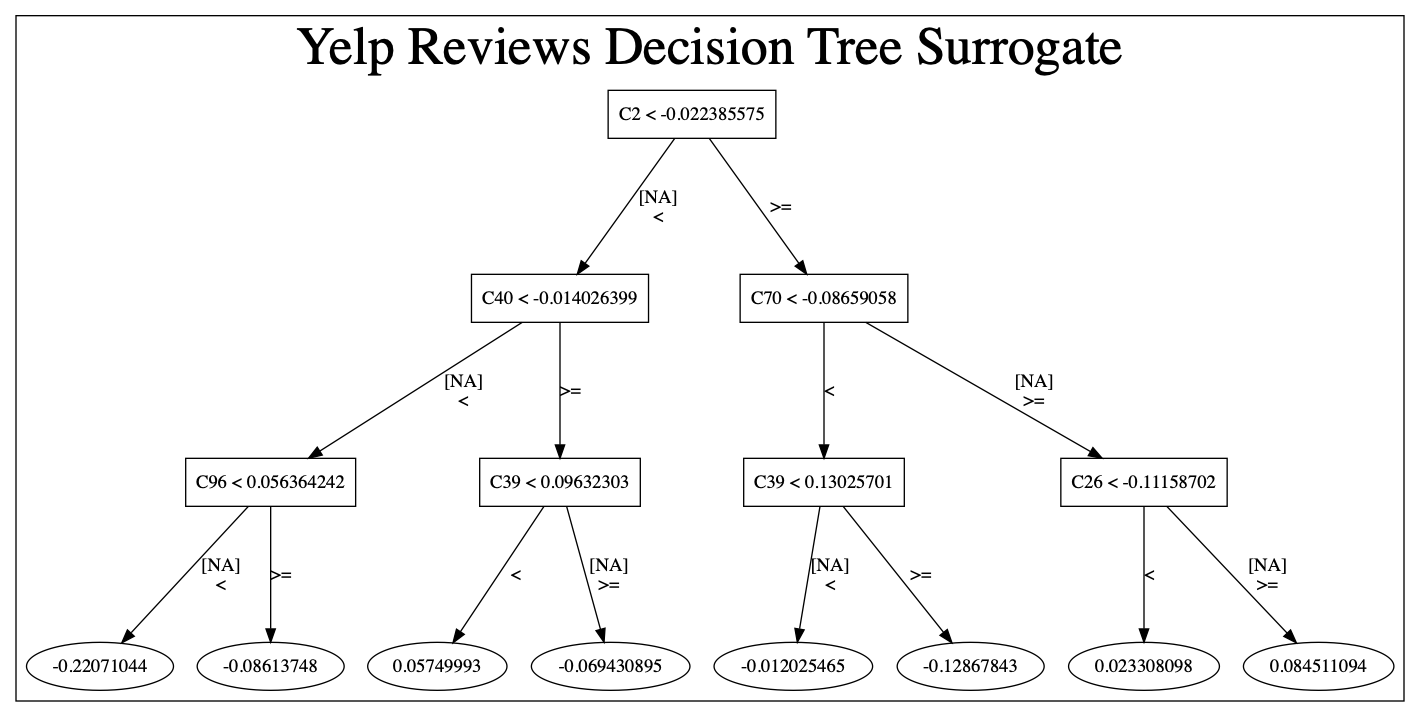

In [53]:
display(Image((png_file_name)))

In [54]:
cleanPath('yelp','dt_surrogate', 'dt_surrogate_mojo.zip')

-------   OK  ---------


### 2.3.2 Interpretability

#### Variable Importance

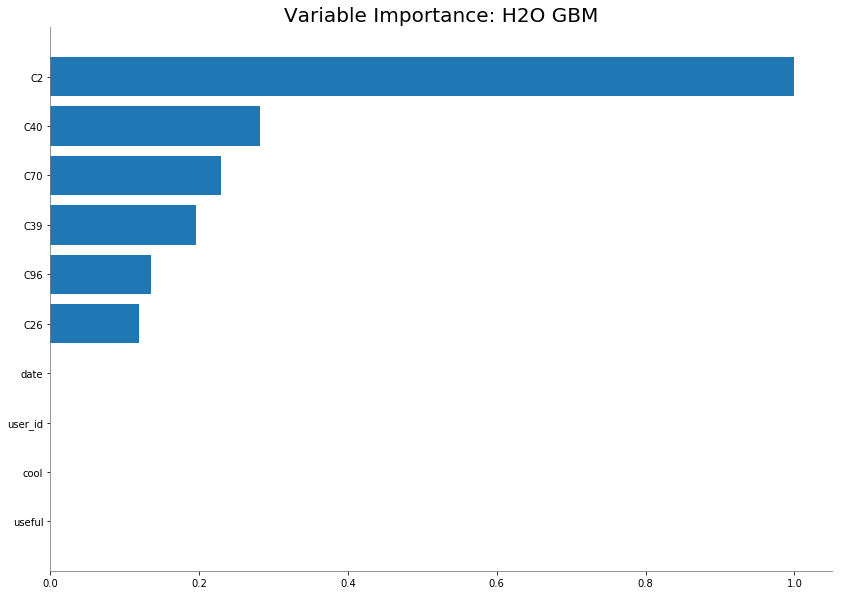

In [55]:
surrogate.varimp_plot()

We can get that the feature "C2" is the most important.

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


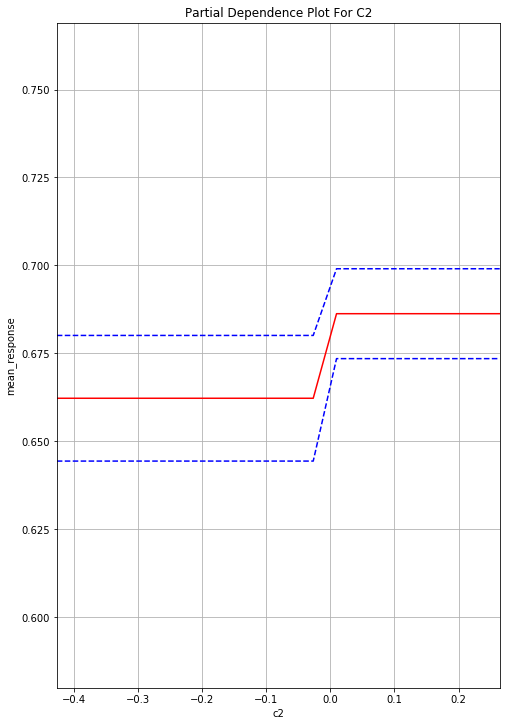

In [57]:
pdp_word_vecs = surrogate.partial_plot(data = ext_train, cols = ["C2"])

PDP for the above model shows that the positive reviews always have a large "C2" score.

#### Individual Conditional Expectation (ICE)

In [58]:
ext_train_dice = h2o.H2OFrame(ext_train.as_data_frame().iloc[::30])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [59]:
C2_ice_df = ice(data=ext_train_dice, column='C2', model=surrogate)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


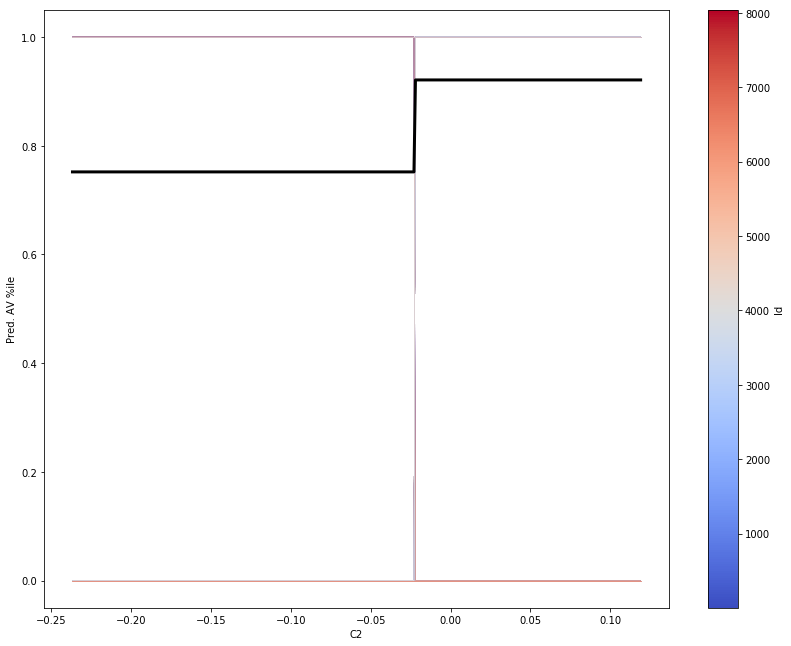

In [60]:
ice_plot(C2_ice_df, linewidth=0.5, color_by='Id', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C2_ice_df.columns.get_level_values('Id').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Id')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C2');

We can get the reviews always be positive review when it's "C2" is bigger than -0.025.

### 2.3.3 Matrix

In [61]:
print(surrogate)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.2108478881405354
RMSE: 0.4591817593726208
LogLoss: 0.6114939539864253
Mean Per-Class Error: 0.3104958921838952
AUC: 0.7409740940295988
pr_auc: 0.4355149927107001
Gini: 0.4819481880591976
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6586455151645662: 


,0,1,Error,Rate
0,631.0,1969.0,0.7573,(1969.0/2600.0)
1,214.0,5254.0,0.0391,(214.0/5468.0)
Total,845.0,7223.0,0.2706,(2183.0/8068.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6586455,0.8279883,5.0
max f2,0.6277768,0.9131597,7.0
max f0point5,0.6751072,0.7972470,3.0
max accuracy,0.6623917,0.7305404,4.0
max precision,0.6959134,0.8623188,0.0
max recall,0.6277768,1.0,7.0
max specificity,0.6959134,0.8465385,0.0
max absolute_mcc,0.6751072,0.3693586,3.0
max min_per_class_accuracy,0.6828087,0.6396154,2.0
max mean_per_class_accuracy,0.6828087,0.6895041,2.0


Gains/Lift Table: Avg response rate: 67.77 %, avg score: 67.74 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.3591968,0.6959134,1.2723461,1.2723461,0.8623188,0.6959134,0.8623188,0.6959134,0.4570227,0.4570227,27.2346087,27.2346087
,2,0.4039415,0.6901673,1.1852997,1.2627039,0.8033241,0.6901673,0.8557840,0.6952769,0.0530358,0.5100585,18.5299714,26.2703945
,3,0.6172533,0.6828087,1.0751128,1.1978758,0.7286461,0.6828087,0.8118474,0.6909681,0.2293343,0.7393928,7.5112843,19.7875775
,4,0.8415964,0.6623917,0.8143747,1.0956465,0.5519337,0.6650120,0.7425626,0.6840490,0.1826993,0.9220922,-18.5625255,9.5646487
,5,0.9252603,0.6490174,0.6732623,1.0574537,0.4562963,0.6551937,0.7166778,0.6814399,0.0563277,0.9784199,-32.6737652,5.7453682
,6,1.0,0.6277768,0.2887368,1.0,0.1956882,0.6277768,0.6777392,0.6774291,0.0215801,1.0,-71.1263240,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-26 20:46:40,0.062 sec,0.0,0.4673422,0.6285618,0.5,0.0,1.0,0.3222608
,2019-04-26 20:46:40,0.110 sec,1.0,0.4591818,0.6114940,0.7409741,0.4355150,1.2723461,0.2705751


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
C2,161.3866882,1.0,0.5095072
C40,45.5410309,0.2821858,0.1437757
C70,37.0551262,0.2296046,0.1169852
C39,31.7017784,0.1964337,0.1000844
C96,21.7721481,0.1349067,0.0687359
---,---,---,---
C95,0.0,0.0,0.0
C97,0.0,0.0,0.0
C98,0.0,0.0,0.0
C99,0.0,0.0,0.0



See the whole table with table.as_data_frame()



## 2.4 Gradient Boosting Model II

### 2.4.1 Train & Fit Model

In [62]:
gbm = H2OGradientBoostingEstimator(stopping_metric = "AUC",
                                           stopping_tolerance = 0.001,
                                           stopping_rounds = 5, 
                                           score_tree_interval = 10, 
                                           model_id = 'gbm.hex')
gbm.train(x = predictors, 
                   y = response,
                  training_frame = ext_train,
                  validation_frame = ext_test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [63]:
# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = gbm.download_mojo(path='../data')

print(gbm)
print('Generated MOJO path:\n', mojo_path)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm.hex


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.09016905617901659
RMSE: 0.30028162810770925
LogLoss: 0.3131031245029406
Mean Per-Class Error: 0.11084787012548536
AUC: 0.9561577148162738
pr_auc: 0.9773709791831261
Gini: 0.9123154296325475
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5609709436267906: 


,0,1,Error,Rate
0,2099.0,501.0,0.1927,(501.0/2600.0)
1,314.0,5154.0,0.0574,(314.0/5468.0)
Total,2413.0,5655.0,0.101,(815.0/8068.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5609709,0.9267284,217.0
max f2,0.3983792,0.9529025,277.0
max f0point5,0.7002930,0.9347425,164.0
max accuracy,0.5609709,0.8989836,217.0
max precision,0.9865452,1.0,0.0
max recall,0.0466371,1.0,397.0
max specificity,0.9865452,1.0,0.0
max absolute_mcc,0.6074409,0.7675065,199.0
max min_per_class_accuracy,0.6548718,0.8866130,181.0
max mean_per_class_accuracy,0.6481650,0.8891521,184.0


Gains/Lift Table: Avg response rate: 67.77 %, avg score: 67.74 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100397,0.9721253,1.4754938,1.4754938,1.0,0.9761125,1.0,0.9761125,0.0148135,0.0148135,47.5493782,47.5493782
,2,0.0200793,0.9674271,1.4754938,1.4754938,1.0,0.9696953,1.0,0.9729039,0.0148135,0.0296269,47.5493782,47.5493782
,3,0.0301190,0.9638244,1.4754938,1.4754938,1.0,0.9656641,1.0,0.9704906,0.0148135,0.0444404,47.5493782,47.5493782
,4,0.0400347,0.9601353,1.4754938,1.4754938,1.0,0.9618359,1.0,0.9683470,0.0146306,0.0590710,47.5493782,47.5493782
,5,0.0500744,0.9562663,1.4754938,1.4754938,1.0,0.9583398,1.0,0.9663406,0.0148135,0.0738844,47.5493782,47.5493782
,6,0.1000248,0.9421571,1.4718325,1.4736654,0.9975186,0.9490150,0.9987608,0.9576885,0.0735187,0.1474031,47.1832507,47.3665413
,7,0.1500992,0.9284278,1.4754938,1.4742754,1.0,0.9351365,0.9991742,0.9501650,0.0738844,0.2212875,47.5493782,47.4275373
,8,0.2000496,0.9142361,1.4681712,1.4727512,0.9950372,0.9214834,0.9981413,0.9430035,0.0733358,0.2946233,46.8171232,47.2751229
,9,0.3000744,0.8814333,1.4498966,1.4651330,0.9826518,0.8982543,0.9929781,0.9280871,0.1450256,0.4396489,44.9896616,46.5133024
,10,0.3999752,0.8424517,1.4333891,1.4572044,0.9714640,0.8625367,0.9876046,0.9117147,0.1431968,0.5828456,43.3389121,45.7204426




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.14198384708589887
RMSE: 0.3768074403271502
LogLoss: 0.4389555479848488
Mean Per-Class Error: 0.2284743272003611
AUC: 0.8450464809884005
pr_auc: 0.9174244941242724
Gini: 0.690092961976801
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4490158724892611: 


,0,1,Error,Rate
0,313.0,309.0,0.4968,(309.0/622.0)
1,107.0,1289.0,0.0766,(107.0/1396.0)
Total,420.0,1598.0,0.2061,(416.0/2018.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4490159,0.8610554,267.0
max f2,0.1736435,0.9296113,363.0
max f0point5,0.6749744,0.8586412,179.0
max accuracy,0.4490159,0.7938553,267.0
max precision,0.9808585,1.0,0.0
max recall,0.1180084,1.0,380.0
max specificity,0.9808585,1.0,0.0
max absolute_mcc,0.6749744,0.5162097,179.0
max min_per_class_accuracy,0.6918596,0.7668810,172.0
max mean_per_class_accuracy,0.6749744,0.7715257,179.0


Gains/Lift Table: Avg response rate: 69.18 %, avg score: 67.96 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0104063,0.9704646,1.4455587,1.4455587,1.0,0.9753177,1.0,0.9753177,0.0150430,0.0150430,44.5558739,44.5558739
,2,0.0203171,0.9673902,1.3732808,1.4103012,0.95,0.9687372,0.9756098,0.9721077,0.0136103,0.0286533,37.3280802,41.0301209
,3,0.0302279,0.9626412,1.4455587,1.4218611,1.0,0.9653939,0.9836066,0.9699064,0.0143266,0.0429799,44.5558739,42.1861055
,4,0.0401388,0.9581843,1.3732808,1.4098659,0.95,0.9602822,0.9753086,0.9675301,0.0136103,0.0565903,37.3280802,40.9865931
,5,0.0500496,0.9544418,1.3732808,1.4026214,0.95,0.9563918,0.9702970,0.9653245,0.0136103,0.0702006,37.3280802,40.2621351
,6,0.1000991,0.9413099,1.4312463,1.4169338,0.9900990,0.9480114,0.9801980,0.9566679,0.0716332,0.1418338,43.1246276,41.6933814
,7,0.1501487,0.9268199,1.4169338,1.4169338,0.9801980,0.9345054,0.9801980,0.9492804,0.0709169,0.2127507,41.6933814,41.6933814
,8,0.2001982,0.9116108,1.3453715,1.3990432,0.9306931,0.9197157,0.9678218,0.9418892,0.0673352,0.2800860,34.5371500,39.9043235
,9,0.3002973,0.8709114,1.2952779,1.3644548,0.8960396,0.8913483,0.9438944,0.9250422,0.1296562,0.4097421,29.5277880,36.4454784
,10,0.3999009,0.8213089,1.2801465,1.3434561,0.8855721,0.8465984,0.9293680,0.9055042,0.1275072,0.5372493,28.0146545,34.3456077



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-04-26 20:48:16,0.037 sec,0.0,0.4673422,0.6285618,0.5,0.0,1.0,0.3222608,0.4619737,0.6181283,0.5,0.0,1.0,0.3082260
,2019-04-26 20:48:16,0.312 sec,10.0,0.3926710,0.4824309,0.8768515,0.9309910,1.4754938,0.1818294,0.4067233,0.5075804,0.8150187,0.8939476,1.3078865,0.2333994
,2019-04-26 20:48:16,0.688 sec,20.0,0.3578009,0.4159044,0.9092988,0.9507981,1.4754938,0.1534457,0.3900778,0.4713193,0.8308592,0.9078674,1.3767226,0.2234886
,2019-04-26 20:48:16,0.881 sec,30.0,0.3341309,0.3719455,0.9298085,0.9626710,1.4754938,0.1311353,0.3828229,0.4540497,0.8382632,0.9114490,1.3767226,0.2200198
,2019-04-26 20:48:17,1.162 sec,40.0,0.3160924,0.3398962,0.9443038,0.9701975,1.4754938,0.1145265,0.3787462,0.4443853,0.8424535,0.9146080,1.4455587,0.2111001
,2019-04-26 20:48:17,1.456 sec,50.0,0.3002816,0.3131031,0.9561577,0.9773710,1.4754938,0.1010164,0.3768074,0.4389555,0.8450465,0.9174245,1.4455587,0.2061447


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
C2,867.9242554,1.0,0.1641121
C40,500.9112549,0.5771371,0.0947151
C39,383.3309326,0.4416640,0.0724824
C70,209.7133942,0.2416264,0.0396538
C57,207.5719604,0.2391591,0.0392489
---,---,---,---
C22,3.7854652,0.0043615,0.0007158
C95,3.4491162,0.0039740,0.0006522
C66,2.6330931,0.0030338,0.0004979
useful,2.4562023,0.0028300,0.0004644



See the whole table with table.as_data_frame()

Generated MOJO path:
 /Users/mandy/Desktop/AI-Addin/data/gbm_hex.zip


In [64]:
details = False # print more info on tree, details = True
title = 'Yelp Reviews Decision Tree Surrogate'

hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o ').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)

if details:
    gv_args.append('--detail')

if title is not None:
    gv_args = gv_args + ['--title', title]
    
print()
print('Calling external process ...')
print(' '.join(gv_args))
    
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/mandy/Desktop/AI-Addin/data/gbm_hex.zip -o dt_surrogate_mojo.gv --title Yelp Reviews Decision Tree Surrogate


In [65]:
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

print('Calling external process ...')
print(' '.join(png_args))

_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


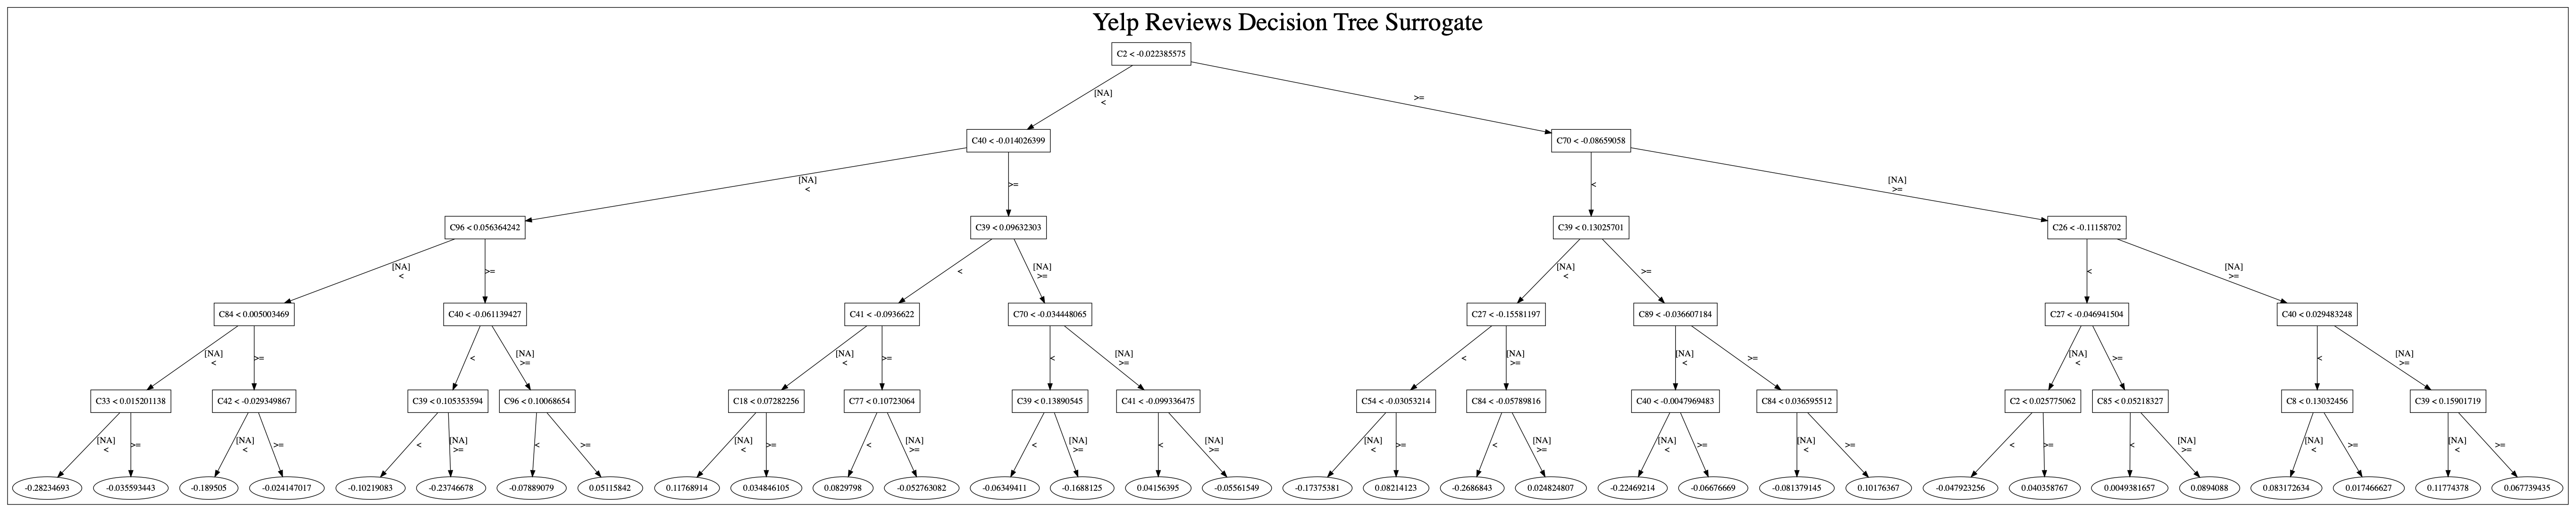

In [66]:
display(Image((png_file_name)))

In [67]:
cleanPath('yelp', 'gbm', 'gbm_hex.zip')

-------   OK  ---------


## 2.4.2 Interpretability

#### Variable Importance

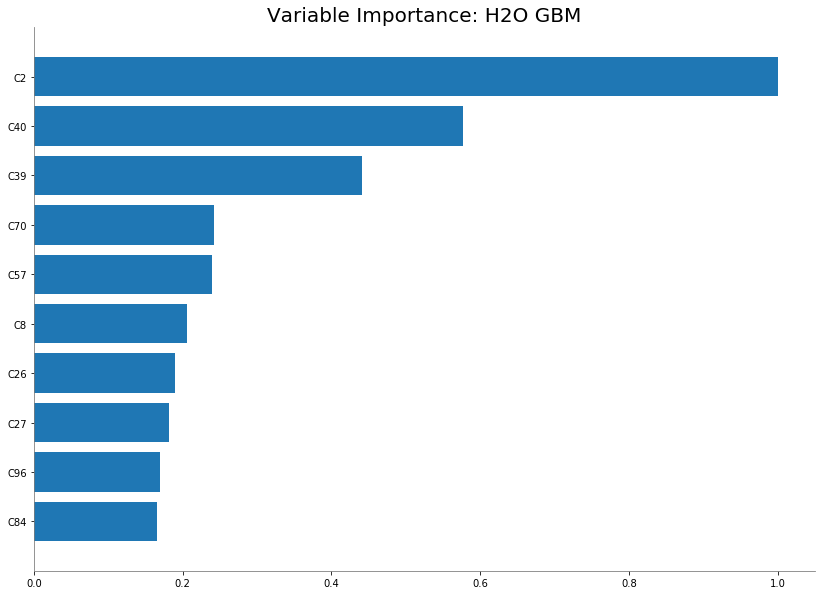

In [68]:
gbm.varimp_plot()

We can get that the feature "C2" is the most important.

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


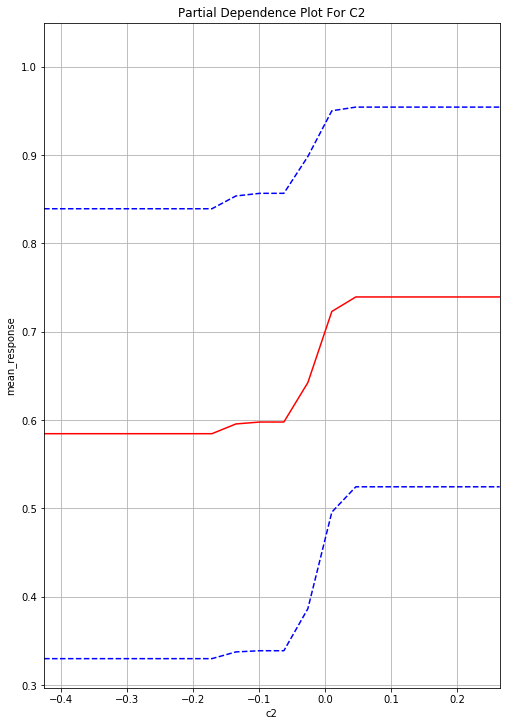

In [69]:
pdp_helpfulness = gbm.partial_plot(ext_train, cols = ['C2'])

PDP for the above model shows that the positive reviews always have a large "C2" score.

#### Individual Conditional Expectation (ICE)

In [70]:
ext_train_gice = h2o.H2OFrame(ext_train.as_data_frame().iloc[::15])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [71]:
ext_train_gice.shape

(538, 111)

In [72]:
C2_ice_df = ice(data=ext_train_gice, column='C2', model=gbm)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


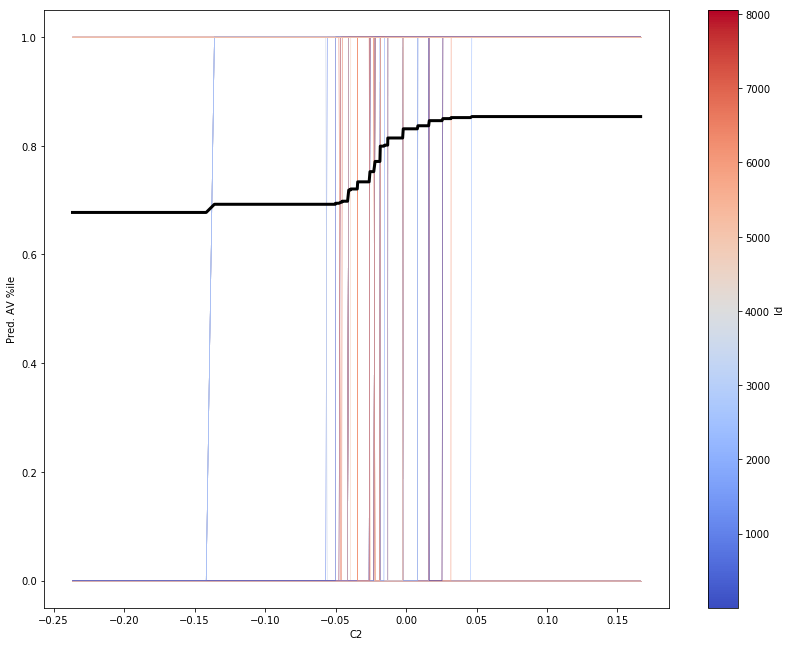

In [73]:
ice_plot(C2_ice_df, linewidth=0.5, color_by='Id', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C2_ice_df.columns.get_level_values('Id').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Id')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C2');

We can get the reviews always be positive review when it's "C2" is bigger than 0.05.

### 2.4.3 Matrix

In [74]:
print("AUC on validation data: " + str(round(gbm.auc(valid = True), 3)))

AUC on validation data: 0.845


In [75]:
gbm.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4490158724892611: 


,0,1,Error,Rate
0,313.0,309.0,0.4968,(309.0/622.0)
1,107.0,1289.0,0.0766,(107.0/1396.0)
Total,420.0,1598.0,0.2061,(416.0/2018.0)


In [76]:
gbm.r2(train=True, valid=True)

{'train': 0.5871546008739235, 'valid': 0.33410545045993145}

# 3 Conclusion

## 3.1 Prototype Testing

As we can see the plots of prototype and new dataset in Result part, we can draw the conclusion that our interpretable prototype does well at least in review type of dataset, with the prove that we only slightly adjust the code to fit the new dataset and it still runs well.

## 3.2 Models Comparison

| Model | AUC |
| --- | --- |
| Generalized Linear Model | 0.8755778023183839 |
| Logistic Regression | 0.846 |
| Gradient Boosting Model I | 0.7409740940295988 |
| Gradient Boosting Model II | 0.845 |

From the table above, we can easily select the model with the best performance based on matrix AUC score. In this case, **Generalized Linear Model** has the highest AUC score, which is .876. Thus, all interpretable explanation will based on model **Generalized Linear Model**.

## 3.3 Interpretability

This project is going to build an artificial intelligence software called AI-addin, which can automatically apply model interpretability algorithms to any data set that a user uploads for analysis. It can be applied in many fields, such as finance, commercial and medical[1].<br>
In the work for our final project, we did interpretability explaintion for all models we built. Here we use Generalization Linear Model as an example(2.1.2). we plotted three plots:
- Variable Inportance: 
To choose which variable has the most important influences for our prediction. We can get that the feature "cool" is the most important.

- Partial Dependence Plot (PDP):
The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model.[2] PDP for the first model shows that the positive reviews always have a large "cool" score.

- Individual Conditional Expectation (ICE)
Individual Conditional Expectation (ICE) plots display one line per instance that shows how the instance’s prediction changes when a feature changes.[3] We can get the reviews always be positive review when it's "cool" is bigger than 15.

# 4 Citations

* [1] https://github.com/skunkworksneu/Projects/blob/master/AI-addin.pdf
* [2] Friedman, Jerome H. “Greedy function approximation: A gradient boosting machine.” Annals of statistics (2001): 1189-1232.
* [3] https://christophm.github.io/interpretable-ml-book/ice.html

# 5 License

This work by AI-Addin project group is licensed under [The Creative Commons Attribution 3.0 License](https://creativecommons.org/licenses/by/3.0/us/)

In [22]:
# h2o.cluster().shutdown()

H2O session _sid_970d closed.
